# House Price Prediction Model

In [5]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [6]:
# import dataset
df = pd.read_csv("Challenge Datasets/train.csv")
df

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5
...,...,...,...,...,...,...,...,...,...,...,...,...
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0
29447,Owner,0,0,2,BHK,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,16.0
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0


In [7]:
# Get shape of df
df.shape # = (29451, 12)

# Analyse types of entries of each column
df.dtypes

# Make column names lowercase and rename where appropriate
df = df.rename(columns={"POSTED_BY":"posted_by","UNDER_CONSTRUCTION":"under_construction","RERA":"rera",
                   "BHK_NO.":"room_count","BHK_OR_RK":"bhk_or_rk","SQUARE_FT":"sq_ft", 
                   "READY_TO_MOVE":"ready_to_move","RESALE":"pre_owned","ADDRESS":"address",
                   "LONGITUDE":"longitude","LATITUDE":"latitude","TARGET(PRICE_IN_LACS)":"price"})

In [8]:
df.columns

Index(['posted_by', 'under_construction', 'rera', 'room_count', 'bhk_or_rk',
       'sq_ft', 'ready_to_move', 'pre_owned', 'address', 'longitude',
       'latitude', 'price'],
      dtype='object')

# Data Exploration & Cleaning

In this section we will be exploring the data in each column of our dataframe and then carry out some cleaning of the data in order to ensure we have a good dataset with which to fit our prediction model.

In the exploration part of this process, we will be carrying univariate and bi-variate analysis of our data to develop a general overview of the data we have on each of our explanatory variables and understand how it affects the price, as well as look for any correlation with our other explanatory variables which we might need to account for when choosing and fitting our prediction model.

In the cleaning part of the process, we will be looking for any missing or outlier values in our dataset, and then decide how to deal with them appropriately by either removing them, imputing them, or using some other technique.


In [9]:
# Initial check for missing values
df.isna().sum() # No missing values therefore only need to worry about treating outliers

# For this prediction model, we will only be considering constructed houses
df = df[df.under_construction == 0].drop(columns='under_construction')

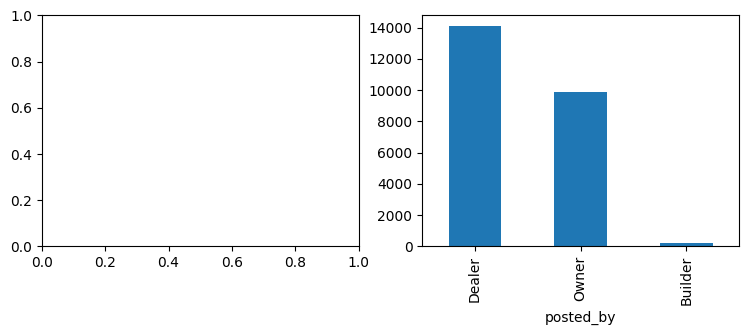

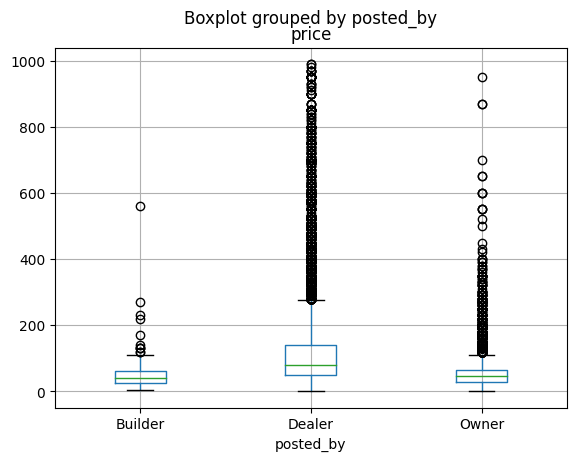

                 sum_sq       df           F        PR(>F)
posted_by  7.223035e+07      2.0  125.676929  5.026206e-55
Residual   6.941019e+09  24154.0         NaN           NaN


In [10]:
### EXPLORATION OF POSTED_BY COLUMN DATA
fig, ax  = plt.subplots(1,2, figsize=(9,3))

# --- Uni-variate Analysis --- #
df.posted_by.unique() # output = ['Owner', 'Dealer', 'Builder'] thus posted_by is a categorical variable
df.posted_by.value_counts()  # output = [Dealer = 14076, Owner = 9875, Builder = 206]
ax[0] = df.posted_by.value_counts().plot(kind='bar')

# --- Bi-variate Analysis --- #
ax[1] = df[df.price < 1000].boxplot(column='price', by='posted_by') # Removed large price values from the plot so the boxes are more clearly visible
plt.show()

# This boxplot shows that we tend to see higher prices when the house is posted by a dealer as oppose to Builder or Owner, however to be rigorous,
# we will perform an ANOVA test to see if the averages of the three groups aer significantly different, and then a t-test so see if the price
# distribution for houses posted by Builders is significantly different to the price distribution for houses posted by Owners

# ANOVA test to see if the averages between our groups are statistically significant
model = ols('price ~ posted_by', data = df).fit()
posted_by_anova_results = sm.stats.anova_lm(model, typ=2)
print(posted_by_anova_results)  # p-value of F-statistic is 5.026206e-55, thus highly significant difference between means of each group

# T-test to see if the price distributions between 'builder' and 'owner' are significantly different
builders_prices = df[df.posted_by == 'Builder']['price']
owner_prices = df[df.posted_by == 'Owner']['price']
posted_by_t_test_results = stats.ttest_1samp(a = builders_prices, popmean=owner_prices.mean())  # T-stat = 2.1496, p_val = 0.03276 
# Thus price distributions are not significantly different at 1% level so we should consider grouping 'builder' and 'owner' categories together 
# under 'other' if we get bad predictions when considering them all separately
# df['posted_by'] = df['posted_by'].apply(lambda x : x if x == 'Owner' else 'Other')


In [11]:
### EXPLORATION OF RERA COLUMN DATA

# --- Univariate Analysis --- #
df.rera.unique() # output = [0,1] thus RERA is a categorical variable
df.rera.value_counts()  # output = [0 = 18393, 1 = 5764]

# --- Bivariate Analysis --- #
## T-test to see if the price distributions between RERA = 0 and RERA = 1 are significatnly different:
rera_zero_prices = df[df.rera == 0]['price']
rera_one_prices = df[df.rera == 1]['price']
rera_t_test_results = stats.ttest_1samp(a = rera_zero_prices, 
                                        popmean=rera_one_prices.mean()) # T-stat = -16.662, p-val = 6.9967e-62
# The T-test results show that price distribution for RERA approved houses is very significantly different to the price distribution for non-approved 
# houses, thus we will include the RERA column as an explanatory variable in our prediction of house price

## Investigating if there is any correlation between RERA approval and who posted the house
builders_rera_value_counts_ratio = df[df.posted_by == 'Builder']['rera'].value_counts()/df[df.posted_by == 'Builder']['rera'].value_counts().sum()   # output = [0 = 0.5583, 1 = 0.4417]
owner_rera_value_counts_ratio = df[df.posted_by == 'Owner']['rera'].value_counts()/df[df.posted_by == 'Owner']['rera'].value_counts().sum()    # output = [0 = 0.8715, 1 = 0.1285]
dealer_rera_value_counts_ratio = df[df.posted_by == 'Dealer']['rera'].value_counts()/df[df.posted_by == 'Dealer']['rera'].value_counts().sum()     # output = [0 = 0.6871, 1 = 0.3128]
# From these results, we see that houses posted by Builders and Dealers have a much higher proportion of RERA approved houses. If our predictions
# are poor then it may be worth looking into finding a way to remove this correlation between our explanatory variables


In [12]:
### EXPLORATION OF BHK OR RK COLUMN DATA

# --- Univariate Analysis --- #
df[df.bhk_or_rk == 'BHK'].shape[0], df[df.bhk_or_rk == 'RK'].shape[0] # output = (24144,13)

# We will drop the entries where the room count is RK since there is very few data points but they vary the interpretation of the room_count column
df2 = df[df.bhk_or_rk == 'BHK'].drop(columns=['bhk_or_rk']) 

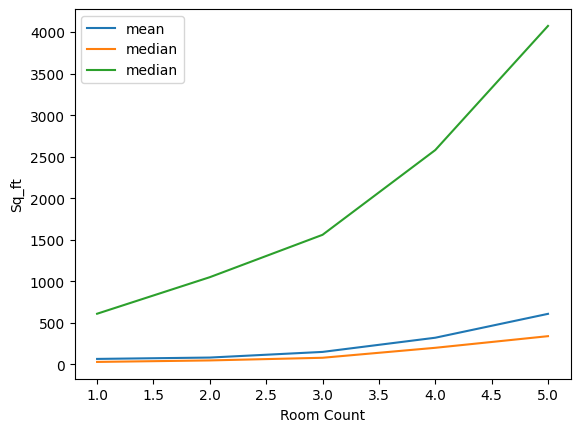

In [13]:
### EXPLORATION OF ROOM_COUNT COLUMN

# --- Univariate Analysis --- #
df2.room_count.dtype, df2.room_count.max(), df2.room_count.min()   # output = 'int64', 20, 1
df2.room_count.value_counts() # Only 84 properties with >= 6 rooms thus we will remove these from the dataset before fitting the regression model
df3 = df2[df2.room_count < 6]


# --- Bivariate Analysis --- #
## Investigating correlation between room count and price of property
price_by_room_count = df3.groupby('room_count',as_index=False).agg({'price':['mean','median']})
plt.plot(price_by_room_count['room_count'],price_by_room_count['price']['mean'], label = 'mean')
plt.plot(price_by_room_count['room_count'],price_by_room_count['price']['median'], label = 'median')
plt.xlabel('Room Count'), plt.ylabel('Price'), plt.legend()

# As we can see from the plot above the mean and median selling prices increase exponentially with the room_count, thus in our linear regression
# we may want to considering using log(price) as an explanatory variable to get a linear relationship between the price and the room_count 
# explanatory variable. This will however require us to check that the relationship log(price) vs x is still linear for our other explanatory
# variables x

## Investigating correlation between room count and sq_ft
sqft_by_room_count = df3.groupby('room_count',as_index=False).agg({'sq_ft':['mean','median']})
#plt.plot(sqft_by_room_count['room_count'],sqft_by_room_count['sq_ft']['mean'], label = 'mean')  # clearly we see the mean here is highly skewed due to an extremely large sq_ft value at room_count = 3
plt.plot(sqft_by_room_count['room_count'],sqft_by_room_count['sq_ft']['median'], label = 'median')
plt.xlabel('Room Count'), plt.ylabel('Sq_ft'), plt.legend()

# From above we see that the median sq_ft increases exponentially with the number of rooms in the property. This strong relationship between 
# explanatory variables may cause poor predictions since certain factors affecting the house price might be accounted for twice (once by the room count
# and once by the sq_ft value), however we will determine whether this issue needs to be dealt with once we have seen the results of our predictions.

plt.show()

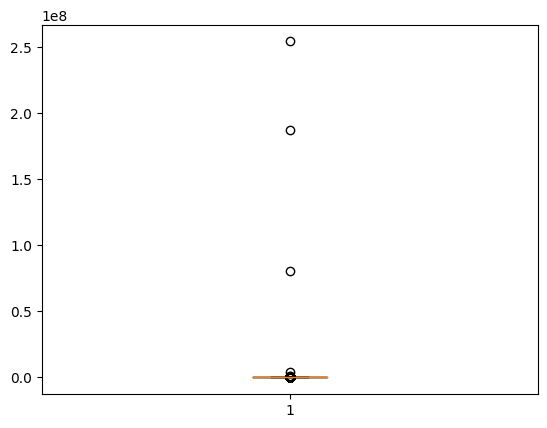

/var/folders/nj/x57yr4dd7cs205xl51ft7lqr0000gp/T/ipykernel_87276/2909633350.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['sqft_bin'] = pd.cut(x=df4['sq_ft'], bins=[0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,10000])


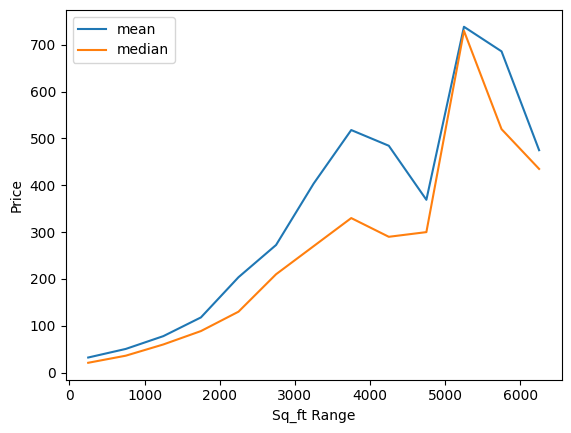

In [14]:
### EXPLORATION OF SQ_FT COLUMN DATA

# --- Univariate Analysis --- #
df3.sq_ft.mean(), df3.sq_ft.median(), df3.sq_ft.max(), df3.sq_ft.min() # output = (23617.789, 1200.0, 254545454.5, 3.0)
df3.sq_ft.quantile(0.001), df3.sq_ft.quantile(0.2), df3.sq_ft.quantile(0.8), df3.sq_ft.quantile(0.95) # output = (102.23, 850.16, 1680.07, 2575.78)
plt.boxplot(df3['sq_ft'])
plt.show()

# As we can see from the stats and plot shown above there are several extremely large outliers for sq_ft values, we want to remove these as they
# cause our regression model to account for them and thus produce worse results fro the majority of cases
# However, as we saw before, the sq_ft value is correlated with the room_count value thus we want to remove the outlier for each value of room_count
# rather than the outliers for the entire dataset. In particular we will only keep values within the 10th and 90th percentiles for each value of 
# room_count
df4 = df3[df3.groupby("room_count").sq_ft.transform(lambda x : (x<x.quantile(0.9))&(x>(x.quantile(0.1)))).eq(1)]


## --- Bivariate Analysis --- ##
## Investigating correlation between sq_ft and price
df4['sqft_bin'] = pd.cut(x=df4['sq_ft'], bins=[0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,10000])
price_by_sqft_bin = df4.groupby("sqft_bin",as_index=False).agg({'price':['mean','median']})
plt.plot([250,750,1250,1750,2250,2750,3250,3750,4250,4750,5250,5750,6250], price_by_sqft_bin['price']['mean'], label = 'mean')
plt.plot([250,750,1250,1750,2250,2750,3250,3750,4250,4750,5250,5750,6250], price_by_sqft_bin['price']['median'], label = 'median')
plt.xlabel('Sq_ft Range'), plt.ylabel('Price'), plt.legend()
plt.show()

# As we can see from this plot, the relationship behaves very non-linearly for sq_ft values above 3500. We now have two choices: 
# 1. We can choose to not use sq_ft as an explanatory variable due to this non-linearity - Despite the fact that sq_ft clearly has an impact on house
# price, this method might be successful due to the correlation between room_count and sq_ft, thus the impact of sq-ft on the house price will be 
# accounted for implicitly via the room_count column
# 2. We can feature engineer a new column 'sq_ft/room' and see if it is linearly related to the house price, in which case we could use this as an
# explanatory variable instead of 'sq_ft' on its own
# We will initially carry out method 1 to make predictions, and afterwards we will carry out method 2 and compare the results of the predictions
# attained using each method


In [15]:
### EXPLORATION OF READY_TO_MOVE COLUMN DATA

# --- Univariate Analysis --- #
df4.ready_to_move.unique() # output = 1
# As we can see from th above output, all entries in this column are equal to 1 thus we can remove it since it is redundant
df5 = df4.drop(columns=['ready_to_move','sqft_bin'])

In [16]:
### EXPLORATION OF PRE_OWNED COLUMN DATA

# --- Univariate Analysis --- #
df5.pre_owned.unique() # output = [0,1]
df5.pre_owned.value_counts() # output = [0 = 418, 1 = 18779]


# --- Bivariate Analysis --- #
## T-test to see if the price distributions between pre_owned = 0 and pre_owned = 1 are significantly different:
pre_owned_zero_prices = df5[df5.pre_owned == 0]['price']
pre_owned_one_prices = df5[df5.pre_owned == 1]['price']
pre_owned_t_test_results = stats.ttest_1samp(a = pre_owned_zero_prices, 
                                             popmean=pre_owned_one_prices.mean()) # T-stat = 1.936, p-val = 0.0535
# This T-test result shows that at the up to the 5% significance level, there is no significant difference in the price distributions of pre-owned vs
# non pre-owned houses, thus we will assume that the value of pre_owned does not impact the house price and remove this explanatory variable from
# our prediction model

df6 = df5.drop(columns=['pre_owned'])

In [17]:
### EXPLORATION OF ADDRESS COLUMN DATA

# --- Univariate Analysis --- #
df6.address.nunique() # output = 5312
# This is a massive amount of values for a categorical variable to take - we want to engineer this feature so that it can only take around 5-10 possible
# values. We will start by using 'city' as an explanatory variable in place of 'address'
df6['address'] = df6['address'].apply(lambda x: x.split(',')[-1])
df7 = df6.rename(columns={'address':'city'})
df7.city.nunique() # output = 221
# 221 is still a very large amount of possible values for the 'city' variable to take, thus we will only have unique city names for the top five cities
# with the most data entries, and group the rest under 'other'
top_5_cities = df7.city.value_counts().head(5).index.tolist()
df7['city'] = df7['city'].apply(lambda x: x if x in top_5_cities else 'other')


# --- Bivariate Analysis --- #
## ANOVA test to see if the difference in averages between our groups are statistically significant
model = ols('price ~ city', data = df7).fit()
city_anova_results = sm.stats.anova_lm(model, typ=2)
print(city_anova_results)  # p-value of F-statistic is 0, thus highly significant difference between means of each group



# Since the longitude & latitude information is already somewhat already accounted for in the 'city' value, we will drop these columns to avoid overfitting
df8 = df7.drop(columns=['longitude','latitude'])

                sum_sq       df          F  PR(>F)
city      3.055261e+07      5.0  387.18882     0.0
Residual  3.028678e+08  19191.0        NaN     NaN


## Fitting the Model with no 'sq_ft' Explanatory Variable

In [18]:
# Create dummy variables for each city and each type of posted_by value
dummy_cols_city = pd.get_dummies(df8['city'])
dummy_cols_posted_by = pd.get_dummies(df8['posted_by'])
df9 = pd.concat([df8,dummy_cols_city,dummy_cols_posted_by], axis='columns').drop(columns=['city','other','posted_by','Builder'])

In [19]:
# Define the X and y
X = df9.drop(columns=['price','sq_ft'])
y = np.log(df9['price'])

# Split X and y into training and test datasets
from sklearn.model_selection import train_test_split
X_calib, X_test, y_calib, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

# Building and testing a linear regression model to predict house price
from sklearn.linear_model import LinearRegression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_calib,y_calib)
lin_reg_model.score(X_test,y_test)

0.6000399003823138

## Fitting the Model w/ 'sq_ft/room' explanatory variable

In [20]:
### CREATING NEW EXPLANATORY VARIABLE
df9 = df8.copy()
df9['sqft_per_room'] = df9['sq_ft']/df9['room_count']

### CHECKING LINEARITY OF SQFT_PER_ROOM vs LOG(PRICE) RELATIONSHIP
#plt.scatter(df9['sqft_per_room'],np.log(df9['price']))
#plt.show()

In [21]:
# Create dummy variables for each city and each type of posted_by value
dummy_cols_city = pd.get_dummies(df9['city'])
dummy_cols_posted_by = pd.get_dummies(df9['posted_by'])
df10 = pd.concat([df9,dummy_cols_city,dummy_cols_posted_by], axis='columns').drop(columns=['city','other','posted_by','Builder'])

In [22]:
# Define the X and y
X = df10.drop(columns=['price','sq_ft'])
y = np.log(df10['price'])

# Split X and y into training and test datasets
from sklearn.model_selection import train_test_split
X_calib, X_test, y_calib, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

# Building and testing a linear regression model to predict house price
from sklearn.linear_model import LinearRegression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_calib,y_calib)
lin_reg_model.score(X_test,y_test)

0.6402336115082236